In [ ]:
pip install tensorflow matplotlib pillow numpy


#VGG19 Model for clinical validation

Epoch 1/50
4/4 [==============================] - 37s 7s/step - loss: 26.8575 - accuracy: 0.5000 - val_loss: 26.6321 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
4/4 [==============================] - 28s 7s/step - loss: 25.8051 - accuracy: 0.6250 - val_loss: 26.7166 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/50
4/4 [==============================] - 28s 7s/step - loss: 24.9873 - accuracy: 0.2500 - val_loss: 25.7541 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/50
4/4 [==============================] - 28s 7s/step - loss: 24.1532 - accuracy: 0.3750 - val_loss: 24.9120 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 5/50
4/4 [==============================] - 27s 7s/step - loss: 23.4659 - accuracy: 0.3750 - val_loss: 29.3237 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 6/50
4/4 [==============================] - 27s 7s/step - loss: 22.8318 - accuracy: 0.2500 - val_loss: 37.2141 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 7/50
4/4 [==================

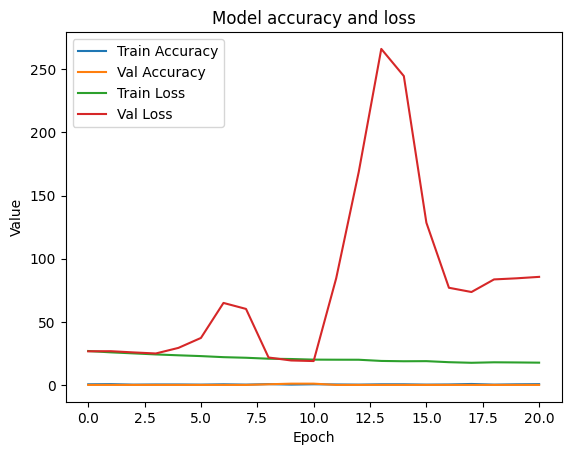

1/1 [==============================] - 1s 1s/step - loss: 18.9117 - accuracy: 1.0000
Training - Loss: 25.50426483154297, Accuracy: 0.5
Validation - Loss: 18.911746978759766, Accuracy: 1.0


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Load images
image_files = [
    '/content/00009221_000.png', '/content/00009218_007.png', '/content/00009216_005.png',
    '/content/00009212_001.png', '/content/00009206_000.png', '/content/00009198_001.png',
    '/content/00009197_000.png', '/content/00009138_021.png', '/content/00009125_001.png',
    '/content/00009124_000.png'
]

images = [Image.open(img_path).resize((224, 224)) for img_path in image_files]

# Convert images to numpy arrays and normalize
image_arrays = np.array([np.array(img) for img in images])
image_arrays = np.stack((image_arrays,) * 3, axis=-1)  # Convert grayscale to RGB by stacking
image_arrays = image_arrays / 255.0

# Generate random labels for a binary classification problem (normal vs abnormal)
labels = np.random.randint(0, 2, size=len(image_files))
labels = to_categorical(labels, num_classes=2)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(image_arrays, labels, test_size=0.2, random_state=42)

# Define data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create the model using a pretrained VGG19 as base
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze some of the last layers of the base model
for layer in base_model.layers[-8:]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Fit the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=2),
    steps_per_epoch=len(X_train) / 2,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

# Display the training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model accuracy and loss')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Evaluate the model on the training and validation data
train_evaluation = model.evaluate(X_train, y_train)
val_evaluation = model.evaluate(X_val, y_val)
print(f'Training - Loss: {train_evaluation[0]}, Accuracy: {train_evaluation[1]}')
print(f'Validation - Loss: {val_evaluation[0]}, Accuracy: {val_evaluation[1]}')


In [ ]:
pip install tensorflow matplotlib pillow numpy lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=a3a22696ab46d06b38d8491526236afcac488c694918975022786e74d0c6f3c7
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


# LIME Analysis

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 7s 7s/step


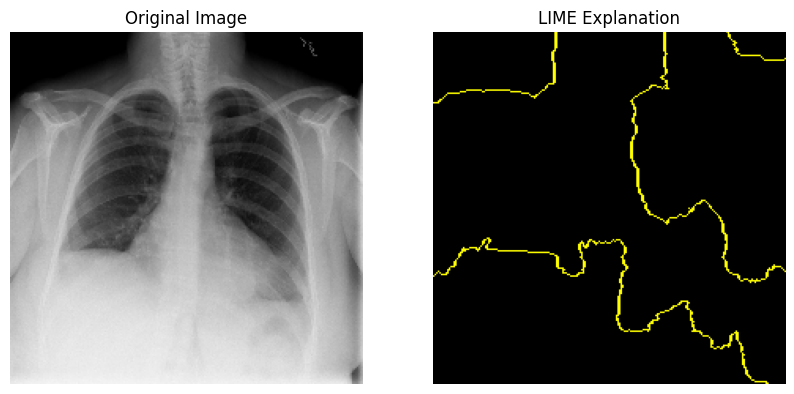

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 7s 7s/step


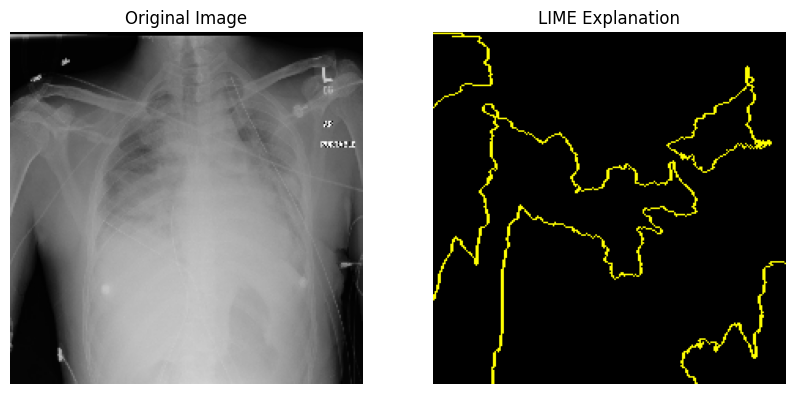

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 7s 7s/step


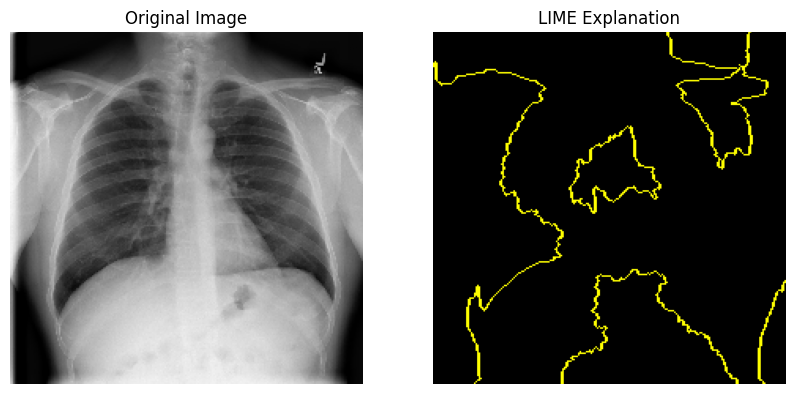

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


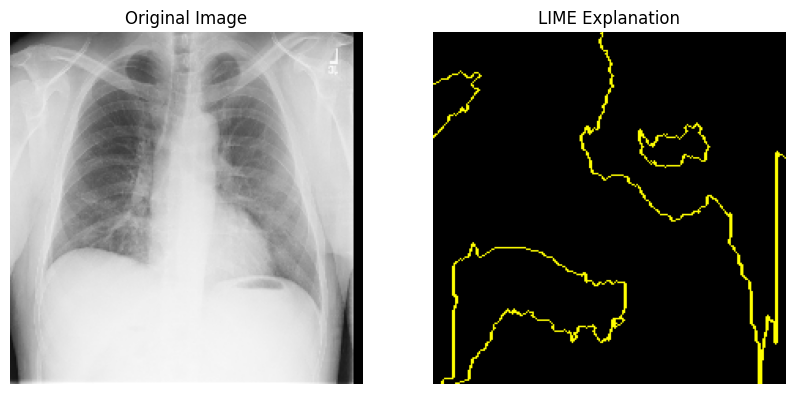

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 8s 8s/step


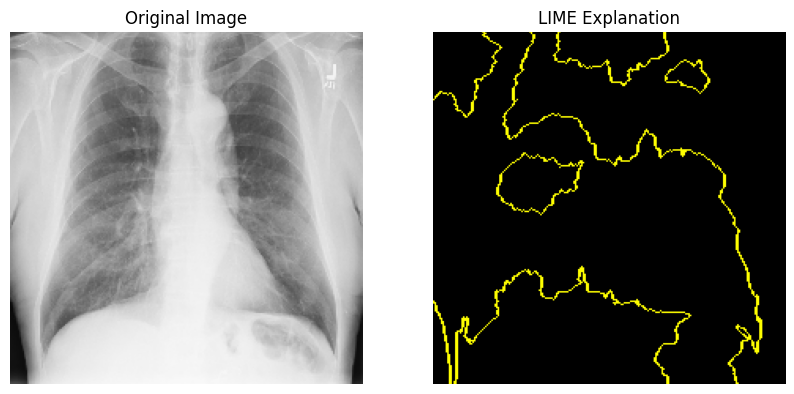

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 8s 8s/step


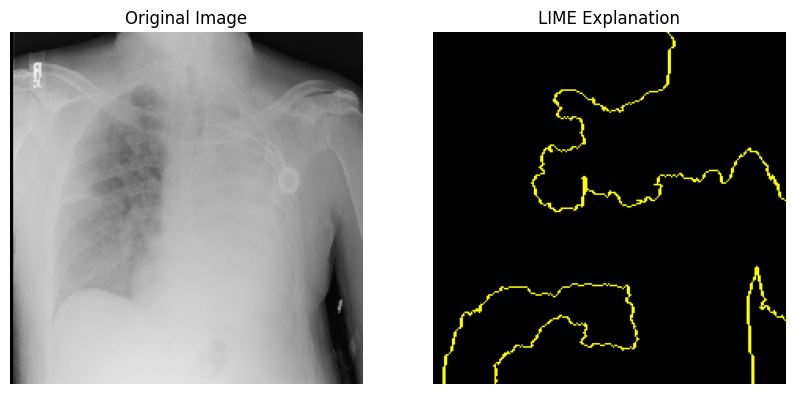

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 7s 7s/step


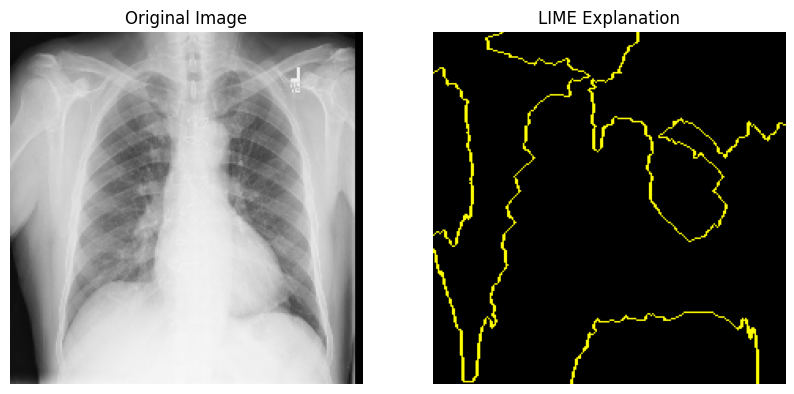

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 6s 6s/step


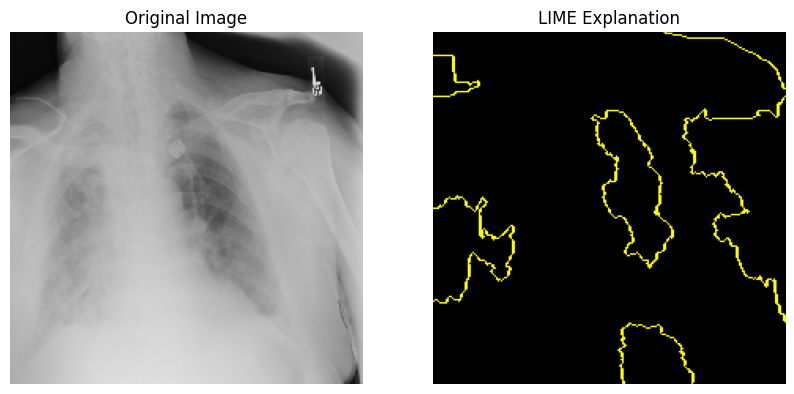

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 7s 7s/step


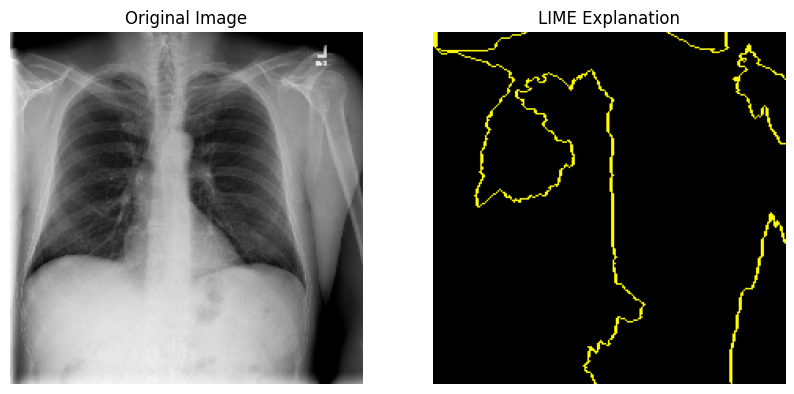

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 8s 8s/step


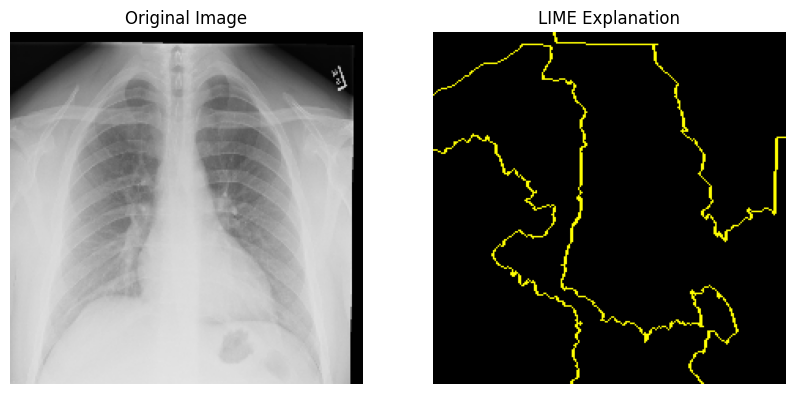

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Load pre-trained model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Function to load images
def load_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    return img_array

# List of image paths (update these to your actual image paths)
image_files = [
    '/content/00009221_000.png', '/content/00009218_007.png', '/content/00009216_005.png',
    '/content/00009212_001.png', '/content/00009206_000.png', '/content/00009198_001.png',
    '/content/00009197_000.png', '/content/00009138_021.png', '/content/00009125_001.png',
    '/content/00009124_000.png'
]

# Load images
images = [load_image(path) for path in image_files]

# Convert list to numpy array and ensure shape is correct
image_arrays = np.array(images)

# Dummy labels for visualization (replace with actual labels)
labels = np.random.randint(0, 2, len(image_files))
labels = np.eye(2)[labels]  # Convert labels to one-hot encoding

# Define a function for LIME to use the model
def predict_fn(images):
    return model.predict(images)

# Initialize LIME
explainer = lime_image.LimeImageExplainer()

def plot_lime_explanations(image_arrays, model, labels):
    for i, image in enumerate(image_arrays):
        explanation = explainer.explain_instance(image, predict_fn, top_labels=1, hide_color=0, num_samples=1000)

        # Get the explanation for the top class
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)

        # Display original image and LIME explanation
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(mark_boundaries(temp / 255.0, mask))
        axes[1].set_title('LIME Explanation')
        axes[1].axis('off')

        plt.show()

# Plot LIME visualizations
plot_lime_explanations(image_arrays, model, labels)


#Vision Transformer (ViT) with Grad-CAM for interpretability

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch

# Load the pre-trained Vision Transformer (ViT) model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs

# List of image paths (update these to your actual image paths)
image_files = [
    '/content/00009221_000.png', '/content/00009218_007.png', '/content/00009216_005.png',
    '/content/00009212_001.png', '/content/00009206_000.png', '/content/00009198_001.png',
    '/content/00009197_000.png', '/content/00009138_021.png', '/content/00009125_001.png',
    '/content/00009124_000.png'
]

# Load and preprocess images
inputs = [load_and_preprocess_image(img_path) for img_path in image_files]
input_tensors = {key: torch.cat([input[key] for input in inputs]) for key in inputs[0].keys()}

# Make predictions
with torch.no_grad():
    outputs = model(**input_tensors)
    logits = outputs.logits
    predicted_class_indices = logits.argmax(-1).tolist()

# Dummy labels for visualization (replace with actual labels if available)
labels = ["Class 0", "Class 1"]  # Replace with your actual class names

# Visualize the results
def visualize_predictions(image_paths, predictions):
    for img_path, pred in zip(image_paths, predictions):
        image = Image.open(img_path)
        plt.imshow(image)
        plt.title(f'Predicted: {labels[pred]}')
        plt.axis('off')
        plt.show()

visualize_predictions(image_files, predicted_class_indices)


#Occlusion Sensitivity Analysis:

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


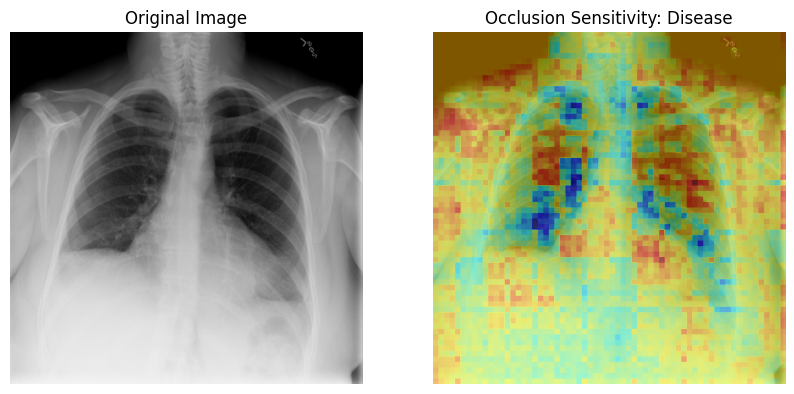

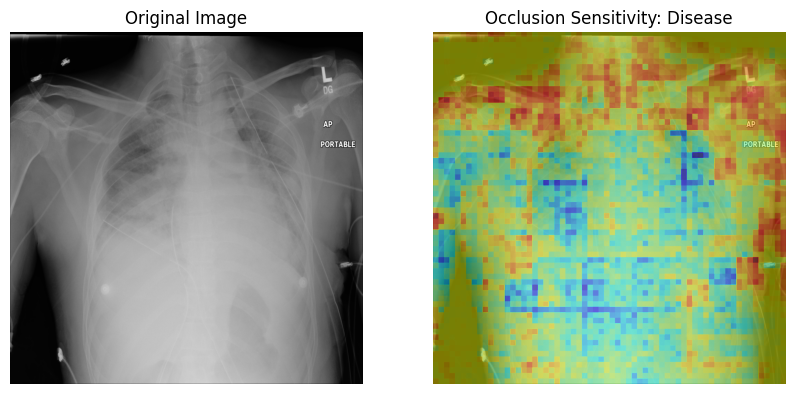

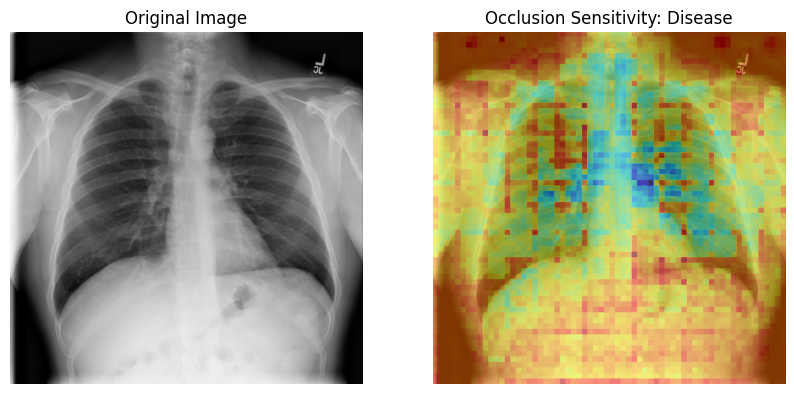

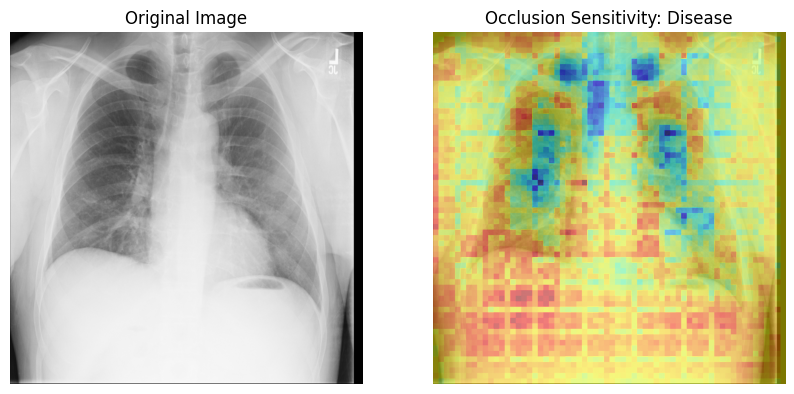

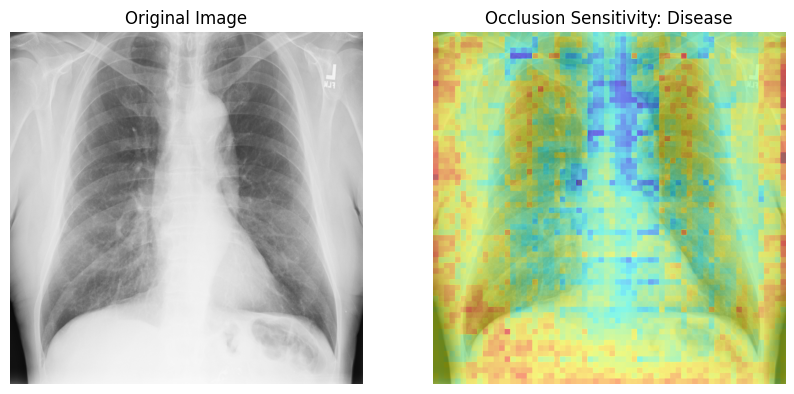

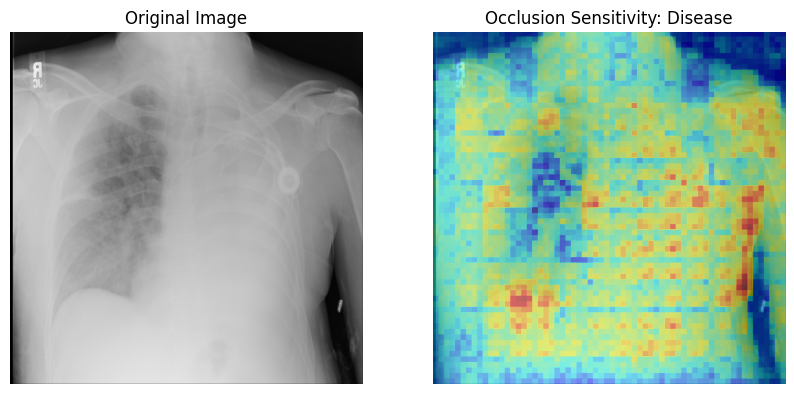

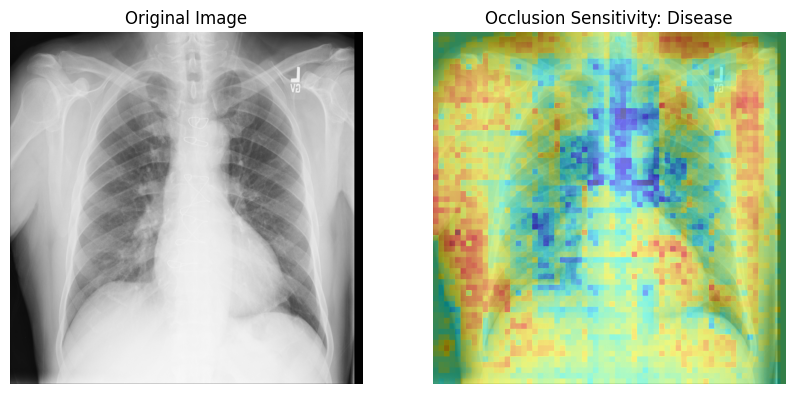

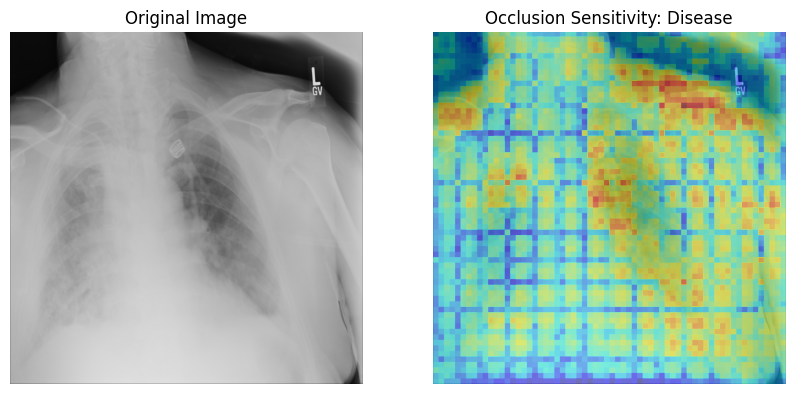

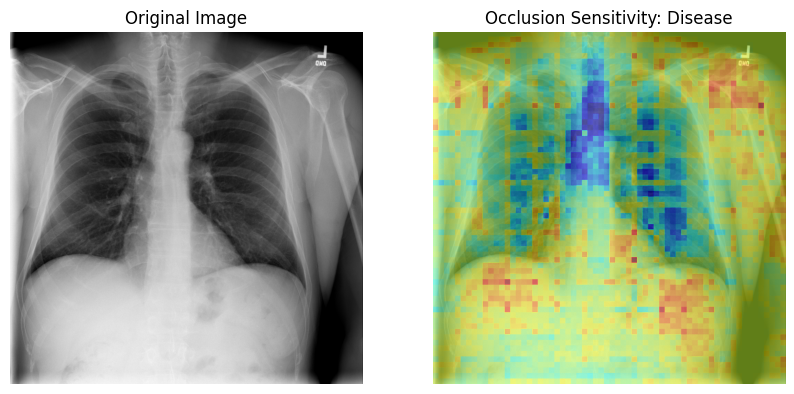

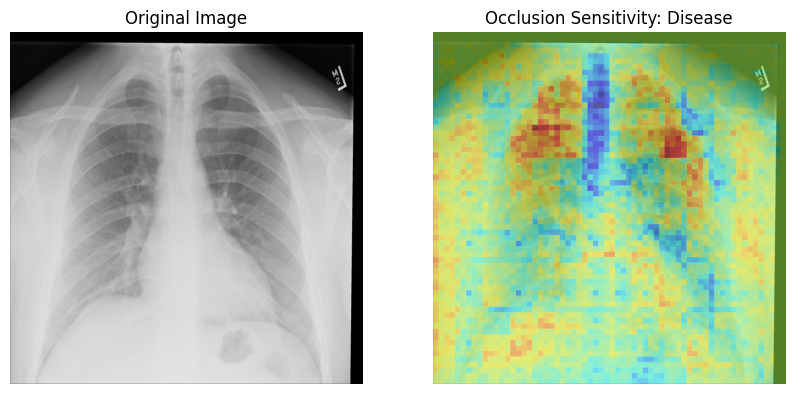

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch

# Load the pre-trained Vision Transformer (ViT) model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs, image

# List of image paths (update these to your actual image paths)
image_files = [
    '/content/00009221_000.png', '/content/00009218_007.png', '/content/00009216_005.png',
    '/content/00009212_001.png', '/content/00009206_000.png', '/content/00009198_001.png',
    '/content/00009197_000.png', '/content/00009138_021.png', '/content/00009125_001.png',
    '/content/00009124_000.png'
]

# Load and preprocess images
inputs_list = [load_and_preprocess_image(img_path) for img_path in image_files]
input_tensors = {key: torch.cat([input[0][key] for input in inputs_list]) for key in inputs_list[0][0].keys()}
images = [input[1] for input in inputs_list]

# Make predictions
with torch.no_grad():
    outputs = model(**input_tensors)
    logits = outputs.logits
    predicted_class_indices = logits.argmax(-1).tolist()

# Dummy labels for visualization (replace with actual labels if available)
labels = ["Normal", "Disease"]  # Replace with your actual class names

# Occlusion Sensitivity Analysis
def occlusion_sensitivity(image, model, feature_extractor, patch_size=16):
    image_array = np.array(image)
    height, width, _ = image_array.shape
    heatmap = np.zeros((height, width))

    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            occluded_image = image_array.copy()
            occluded_image[i:i+patch_size, j:j+patch_size] = 0  # Occlude patch

            inputs = feature_extractor(images=occluded_image, return_tensors="pt")
            with torch.no_grad():
                logits = model(**inputs).logits
                score = logits[0, predicted_class_indices[0]].item()

            heatmap[i:i+patch_size, j:j+patch_size] = score

    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))  # Normalize heatmap
    return heatmap

# Visualize Occlusion Sensitivity Analysis
def visualize_occlusion(image_paths, images, model, feature_extractor, predictions, labels):
    for img_path, image, pred in zip(image_paths, images, predictions):
        heatmap = occlusion_sensitivity(image, model, feature_extractor)

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(image)
        axes[1].imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
        axes[1].set_title(f'Occlusion Sensitivity: {labels[pred]}')
        axes[1].axis('off')

        plt.show()

# Visualize the occlusion sensitivity
visualize_occlusion(image_files, images, model, feature_extractor, predicted_class_indices, labels)


# SHAP analysis


In [4]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 11.5 MB/s eta 0:00:00


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch
import shap

# Load the pre-trained Vision Transformer (ViT) model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs, image

# List of image paths (update these to your actual image paths)
image_files = [
    '/content/00009221_000.png', '/content/00009218_007.png', '/content/00009216_005.png',
    '/content/00009212_001.png', '/content/00009206_000.png', '/content/00009198_001.png',
    '/content/00009197_000.png', '/content/00009138_021.png', '/content/00009125_001.png',
    '/content/00009124_000.png'
]

# Load and preprocess images
inputs_list = [load_and_preprocess_image(img_path) for img_path in image_files]
input_tensors = {key: torch.cat([input[0][key] for input in inputs_list]) for key in inputs_list[0][0].keys()}
images = [input[1] for input in inputs_list]

# Make predictions
with torch.no_grad():
    outputs = model(**input_tensors)
    logits = outputs.logits
    predicted_class_indices = logits.argmax(-1).tolist()

# Dummy labels for visualization (replace with actual labels if available)
labels = ["Normal", "Disease"]  # Replace with your actual class names

# SHAP explanation
def explain_with_shap(model, images):
    def vit_forward(x):
        inputs = feature_extractor(images=[Image.fromarray((img * 255).astype(np.uint8)) for img in x], return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.logits.softmax(dim=-1).cpu().numpy()

    # Convert images to numpy arrays
    image_arrays = np.array([np.array(img) for img in images])

    # Create a SHAP explainer
    explainer = shap.Explainer(vit_forward, image_arrays)
    shap_values = explainer(image_arrays, max_evals=2049)

    return shap_values

# Generate SHAP explanations
shap_values = explain_with_shap(model, images)

# Visualize the SHAP explanations
def visualize_shap(image_paths, shap_values, predictions):
    for i, (img_path, shap_value, pred) in enumerate(zip(image_paths, shap_values, predictions)):
        image = Image.open(img_path)

        # Plot the original image
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # Plot the SHAP values overlayed on the image
        shap.image_plot(shap_value.values, np.array(image), axes=axes[1])
        axes[1].set_title(f'SHAP Explanation: {labels[pred]}')
        axes[1].axis('off')

        plt.show()

# Visualize the SHAP explanations
visualize_shap(image_files, shap_values, predicted_class_indices)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: 'numpy.ndarray' object is not callable

#Implementing Segmented Perturbation Analysis

In [12]:
pip install transformers tensorflow matplotlib pillow numpy torch scikit-image


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21